# Reintegrate RNA

# Set-up

In [1]:
# Import packages
import os
import sys
import yaml
import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 0

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set sc verbosity
sc.settings.verbosity = 0

%load_ext rpy2.ipython
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


by .GlobalEnv when processing object ‘.pbd_env’


In [2]:
sys.path.append("/cellar/users/aklie/projects/igvf/single_cell_utilities")
from cell_type_annotation.utils import check_marker_genes
from plot.covariates import grouped_proportion_barplot, prettier_grouped_proportion_barplot, plot_cluster_counts, pretty_umap, combined_cluster_proportions

In [3]:
# config path
path_config = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/bin/4_integration/configs/round_2_RNA_12-1.yaml"

In [4]:
# Read params from config
with open(path_config, "r") as f:
    config = yaml.safe_load(f)

path_h5ad = config["path_h5ad"]
path_marker_genes = config["path_marker_genes"]
path_sample_metadata = config["path_sample_metadata"]
path_outdir = config["path_outdir"]
round = config["round"]
counts_layer = config["counts_layer"]
umap_key = config["umap_key"]
pca_key = config["pca_key"]
clustering_key = config["clustering_key"]
categorical_covariates = config["categorical_covariates"]
continuous_covariates = config["continuous_covariates"]

print(f"Path h5ad: {path_h5ad}")
print(f"Path marker genes: {path_marker_genes}")
print(f"Path sample metadata: {path_sample_metadata}")
print(f"Path outdir: {path_outdir}")
print(f"Round: {round}")
print(f"Counts layer: {counts_layer}")
print(f"UMAP key: {umap_key}")
print(f"PCA key: {pca_key}")
print(f"Clustering key: {clustering_key}")
print(f"Categorical covariates: {categorical_covariates}")
print(f"Continuous covariates: {continuous_covariates}")

# Confirm they exist
assert os.path.exists(path_h5ad)
assert os.path.exists(path_marker_genes)

# Make figure directory
os.makedirs(os.path.join(path_outdir, "embeddings"), exist_ok=True)
os.makedirs(os.path.join(path_outdir, "clusters"), exist_ok=True)
os.makedirs(os.path.join(path_outdir, "marker_genes"), exist_ok=True)

Path h5ad: /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/4_integration/rna/integrate/round_1_12-1/slim.h5ad
Path marker genes: /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/SC.islet.marker_genes.csv
Path sample metadata: None
Path outdir: /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/4_integration/rna/integrate/round_2_12-1
Round: round_2
Counts layer: counts
UMAP key: X_umap
PCA key: X_pca
Clustering key: harmony_round_1_leiden_1.0
Categorical covariates: ['sample', 'condition', 'differentiation_batch', 'timepoint']
Continuous covariates: ['pct_counts_mt_post_soupx', 'log1p_total_counts_post_soupx', 'scrublet_doublet_score']


# Load and format data

In [5]:
# Read in AnnData
adata = sc.read_h5ad(path_h5ad)
bcs = adata.obs.index.tolist()
adata

AnnData object with n_obs × n_vars = 236613 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

In [6]:
# Load markers
marker_genes_df = pd.read_csv(path_marker_genes)
marker_genes_dict = marker_genes_df.groupby("cell_id")["gene"].apply(list).to_dict()
marker_genes_in_data = check_marker_genes(adata, marker_genes_dict)
marker_genes_in_data

{'SC.EC': ['TPH1', 'SLC18A1'],
 'SC.alpha': ['GCG', 'ARX'],
 'SC.beta': ['INS', 'IAPP', 'PDX1'],
 'SC.delta': ['SST', 'HHEX'],
 'endocrine_progenitor': ['ZEB2', 'NEUROG3', 'FEV'],
 'pancreatic_progenitor': ['SOX9', 'ONECUT1', 'KRT19'],
 'proliferating_alpha': ['MKI67']}

In [7]:
# Load sample metadata
if path_sample_metadata:
    sample_metadata = pd.read_csv(path_sample_metadata, sep="\t")
    sample_metadata = sample_metadata.dropna(subset=["sample_id"])
    adata_obs = adata.obs.merge(sample_metadata, left_on="sample", right_on="sample_id", how="left")
    adata_obs.index = bcs
    adata.obs = adata_obs
adata.obs.head()

,gex_barcode_cellranger,atac_barcode_cellranger,is_cell_cellranger,excluded_reason_cellranger,gex_raw_reads_cellranger,gex_mapped_reads_cellranger,gex_conf_intergenic_reads_cellranger,gex_conf_exonic_reads_cellranger,gex_conf_intronic_reads_cellranger,gex_conf_exonic_unique_reads_cellranger,...,cell_line,sequencing_batch,multiome_stage,multiome_qc_status,notes,harmony_round_1_leiden_0.2,harmony_round_1_leiden_0.5,harmony_round_1_leiden_0.8,harmony_round_1_leiden_1.0,harmony_round_1_leiden_1.5
dm11a#AAACAGCCACACAATT-1,AAACAGCCACACAATT-1,ACAGCGGGTCGGTTTG-1,1,0,13115,12025,1013,3380,6000,3138,...,A2,NaN,qc'd,pass,NaN,4,5,6,7,13
dm11a#AAACATGCACTTACAG-1,AAACATGCACTTACAG-1,CATTTAGGTGACCTTG-1,1,0,17237,16845,872,2753,12933,2035,...,A2,NaN,qc'd,pass,NaN,0,0,0,4,1
dm11a#AAACATGCATAGTCAT-1,AAACATGCATAGTCAT-1,CATTTAGGTGTACCGC-1,1,0,4302,4073,326,1349,2026,1249,...,A2,NaN,qc'd,pass,NaN,2,3,3,2,10
dm11a#AAACATGCATGAAGTA-1,AAACATGCATGAAGTA-1,CATTTAGGTGAGCGAT-1,1,0,67639,65786,3730,11681,48096,9350,...,A2,NaN,qc'd,pass,NaN,1,1,1,0,0
dm11a#AAACCAACACAATGTT-1,AAACCAACACAATGTT-1,CTTTATCGTTAAAGAC-1,1,0,18652,17979,1316,5025,10551,4535,...,A2,NaN,qc'd,pass,NaN,2,3,3,2,5


In [8]:
# Change variable names
adata.obsm["X_umap"] = adata.obsm[umap_key]
adata.obsm["X_pca"] = adata.obsm[pca_key]
adata

AnnData object with n_obs × n_vars = 236613 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


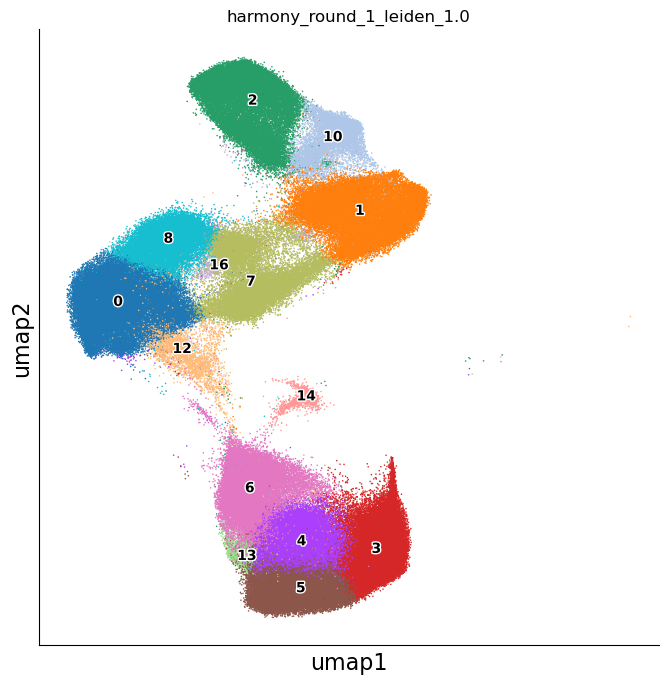

In [9]:
pretty_umap(
    adata,
    color_key=clustering_key,
    s=5,
    figsize=(8, 8),
    legend_fontsize=10,
)

# Filter out samples that failed qc

In [11]:
if path_sample_metadata:
    # Drop samples with fail in multiome_qc_status
    adata_filt = adata[~adata.obs["multiome_qc_status"].isin(["fail"]), :].copy()
else:
    adata_filt = adata.copy()
adata_filt

AnnData object with n_obs × n_vars = 236613 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

In [12]:
# Memory cleanup
del adata

# Reprocess

In [13]:
# Re normalize (needed if filtered out cells)
sc.pp.normalize_total(adata_filt, target_sum=1e4)
sc.pp.log1p(adata_filt)
adata_filt.layers["log1p_norm"] = adata_filt.X.copy()

In [14]:
# Variable genes
sc.pp.highly_variable_genes(adata_filt, n_top_genes=3000)
adata_pca = adata_filt[:, adata_filt.var["highly_variable"]].copy()
adata_pca

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 236613 × 3000
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fra

In [15]:
# Regress out techincal effects
sc.pp.regress_out(adata_pca, ["total_counts_post_soupx", "pct_counts_mt_post_soupx"])

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


In [16]:
# Scale PCA and neighbors
sc.pp.scale(adata_pca, max_value=10)
sc.tl.pca(adata_pca, svd_solver="arpack")

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [17]:
# Transfer over to original with all the genes
adata_filt.obsm["X_pca"] = adata_pca.obsm["X_pca"].copy()
adata_filt.uns["pca"] = adata_pca.uns["pca"].copy()

In [18]:
# Add scaled to layers and re-add counts
adata_filt.X = adata_filt.layers[counts_layer].copy()

# Harmony batch correction
This first cell needs to be done upstream in order to script this notebook

In [19]:
# Grab the PCs
pc = pd.DataFrame(adata_filt.obsm['X_pca'], columns=['PC{}'.format(i) for i in range(1,51)], index=adata_filt.obs.index)
sample = adata_filt.obs['sample'].tolist()
np.unique(sample, return_counts=True)

(array(['0-2', '0-3B-1', '11-1', '12-1', '13-1', '14-1', '14-2', '15-1',
        '15-2', '21-1', '22-1', '22-2', '23-1', '24-1', '24-2', '25-1',
        '31-1', '32-1', '33-1', '34-1', '34-2', '35-1', '41-1', '41-2',
        '42-1', '43-1', '44-1', '44-2', '45-1', 'dm11a', 'dm12b', 'dm14b',
        'dm21a', 'dm23a', 'dm24a', 'dm25a', 'dm31a', 'dm32a', 'dm33a',
        'dm34a', 'dm35a', 'dm42b', 'dm43b', 'dm44a', 'dm45a'], dtype='<U6'),
 array([7724, 6289, 1204, 5622, 5702, 5294, 6209, 4163, 7045, 2257, 8662,
        4489, 6302, 5806, 5603, 5978, 4176, 4155, 7766, 5249, 6876, 3225,
        6399, 6025, 6017, 6792, 5730, 3449, 2809, 4839, 5135, 3041, 4032,
        4232, 4890, 6988, 3906, 3973, 4548, 4879, 4814, 4581, 6822, 7769,
        5147]))

In [20]:
%%R -i pc -i sample -o harmonized
library(harmony)
library(magrittr)

meta_data=matrix(0,length(sample),2)
meta_data[,1]=as.character(sample)
meta_data[,2]=rownames(pc)
colnames(meta_data)=c('sample','cell')
meta_data=as.data.frame(meta_data)
class(meta_data)

batch <- as.factor(unlist(sample))
harmonized <- HarmonyMatrix(pc, meta_data,vars_use='sample',do_pca=FALSE)
harmonized <- data.frame(harmonized)

R[write to console]: Loading required package: Rcpp

R[write to console]: Transposing data matrix

R[write to console]: Initializing state using k-means centroids initialization

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

In [21]:
# cell cluster UMAP
adata_filt.obsm[f'X_harmony_{round}'] = harmonized.values

In [22]:
# kNN
sc.pp.neighbors(adata_filt, use_rep=f"X_harmony_{round}", n_neighbors=30, method='umap', metric='cosine', random_state=1234, n_pcs=50)

In [23]:
# many leidens
sc.tl.leiden(adata_filt, resolution=0.2, key_added=f"harmony_{round}_leiden_0.2", random_state=1234)
sc.tl.leiden(adata_filt, resolution=0.5, key_added=f"harmony_{round}_leiden_0.5", random_state=1234)
sc.tl.leiden(adata_filt, resolution=0.8, key_added=f"harmony_{round}_leiden_0.8", random_state=1234)
sc.tl.leiden(adata_filt, resolution=1.0, key_added=f"harmony_{round}_leiden_1.0", random_state=1234)
sc.tl.leiden(adata_filt, resolution=1.5, key_added=f"harmony_{round}_leiden_1.5", random_state=1234)

In [24]:
# UMAP
sc.tl.umap(adata_filt, min_dist=0.3, spread=1, random_state=1234)

# Analysis

In [25]:
# New clustering key
clustering_key = f'harmony_{round}_leiden_1.0'

## Embeddings

In [26]:
# Plot UMAPs
with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata_filt, color=[clustering_key] + categorical_covariates, frameon=False, wspace=0.5, ncols=2, show=False)
    plt.savefig(os.path.join(path_outdir, "embeddings", f"{clustering_key}_umap_categorical.png"), bbox_inches="tight")
    plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/minicon

In [27]:
# Plot UMAPs
with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata_filt, color=[clustering_key] + continuous_covariates, frameon=False, wspace=0.5, ncols=2, show=False)
    plt.savefig(os.path.join(path_outdir, "embeddings", f"{clustering_key}_umap_continuous.png"), bbox_inches="tight")
    plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/minicon

## Clusters

In [28]:
# Sort the clusters numerically
cluster_order = sorted(adata_filt.obs[clustering_key].unique(), key=lambda x: int(x))[::-1]
cluster_order

['12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']

In [29]:
# Plot
with plt.rc_context({"figure.figsize": (7, 5)}):
    sc.pl.violin(adata_filt, keys=continuous_covariates, groupby=clustering_key, show=False)
    plt.savefig(os.path.join(path_outdir, "clusters", f"{clustering_key}_qc_violin.png"), bbox_inches="tight")
    plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/s

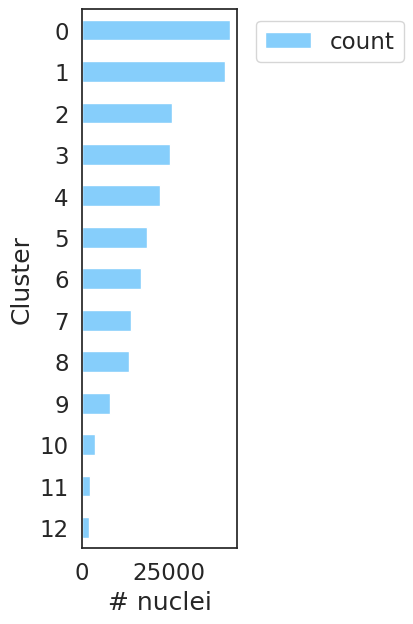

In [30]:
# Counts of cells
plot_cluster_counts(
    adata_filt,
    clustering_key,
    save=os.path.join(path_outdir, "clusters", f"{clustering_key}_cluster_counts.png"),
)

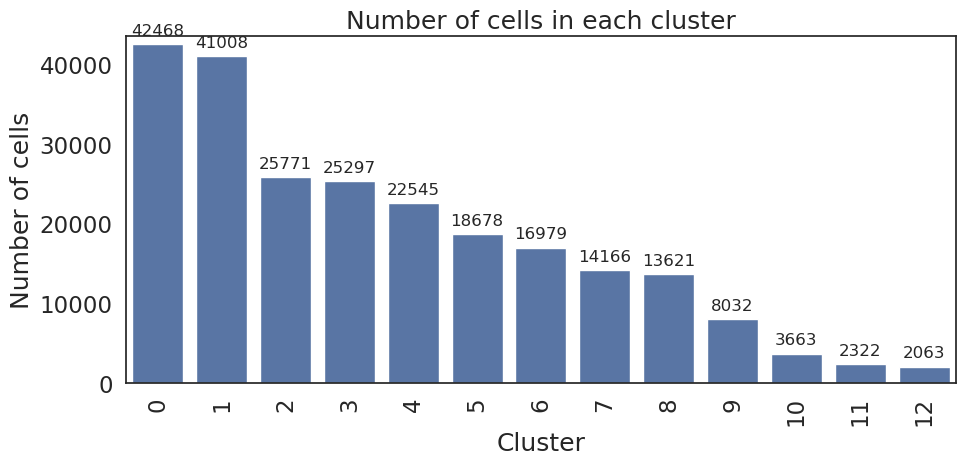

In [31]:
# Number of cells in each cluster
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 5))
    
    # Make spacing fa
    sns.countplot(x=clustering_key, data=adata_filt.obs, order=adata_filt.obs[clustering_key].value_counts().index)
    plt.xticks(rotation=90)
    plt.xlabel("Cluster")
    plt.ylabel("Number of cells")
    plt.title("Number of cells in each cluster")
    
    # Add numbers to the bars
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
    plt.ylim(0, adata_filt.obs[clustering_key].value_counts().max() + 1000)
    plt.tight_layout()
    plt.savefig(os.path.join(path_outdir, "clusters", f"{clustering_key}_num_cells_per_cluster.png"), bbox_inches="tight")

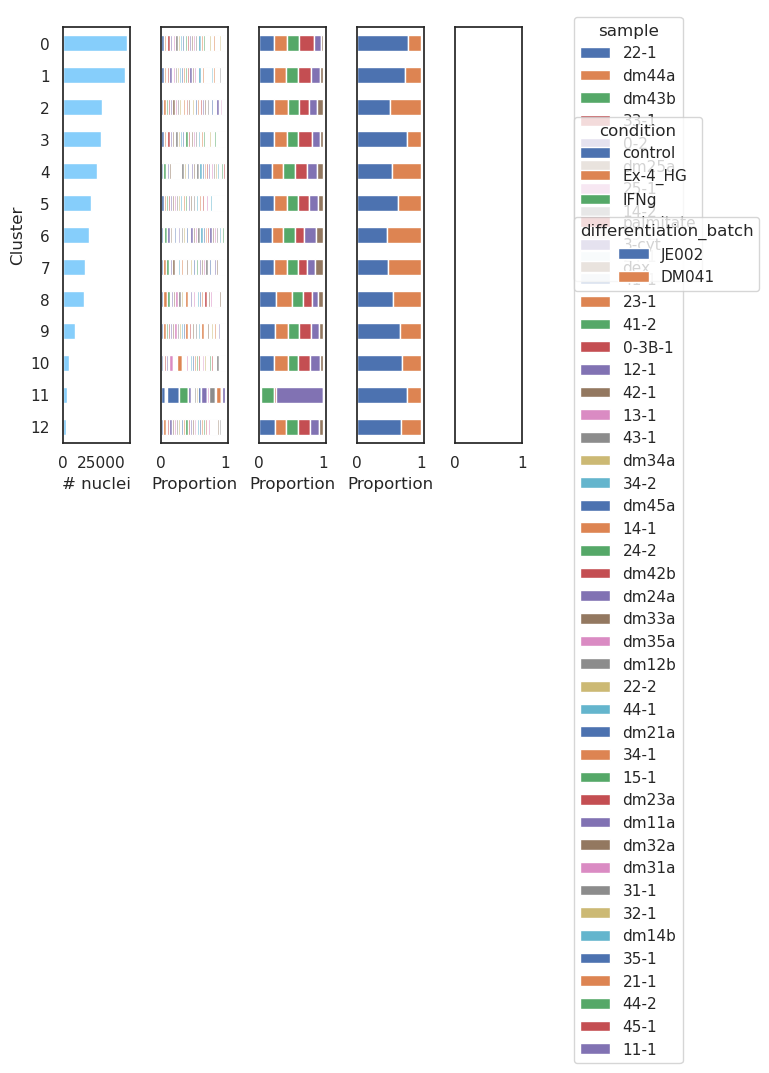

In [32]:
# Usage example
combined_cluster_proportions(
    adata=adata_filt,
    clustering_key=clustering_key,
    proportion_keys=categorical_covariates,
    cluster_order=cluster_order,
    colors_dicts=[None, None, None],
    figsize=(7, 5),
    title="",
    fontscale=1,
    save=os.path.join(path_outdir, "clusters", f"{clustering_key}_combined_proportions.png")
)

## Markers

In [33]:
# 
with plt.rc_context({'axes.facecolor':'white', 'figure.facecolor':'white'}):
    sc.pl.dotplot(
        adata_filt,
        groupby=clustering_key,
        var_names=marker_genes_in_data,
        standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
        layer="log1p_norm",
        expression_cutoff=0,
        show=False,
    )
    plt.savefig(os.path.join(path_outdir, "marker_genes", f"{clustering_key}_dotplot.png"), bbox_inches="tight")
    plt.close()

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided

In [34]:
# Find markers for all leiden_1 clusters
sc.tl.rank_genes_groups(
    adata_filt,
    groupby=clustering_key, 
    method="wilcoxon", 
    layer="log1p_norm", 
    use_raw=False
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [35]:
# Plot markers
with plt.rc_context({"figure.figsize": (7, 5)}):
    sc.pl.rank_genes_groups(adata_filt, n_genes=25, groupby=clustering_key, show=False)
    plt.savefig(os.path.join(path_outdir, "marker_genes", f"{clustering_key}_cluster_markers.png"), bbox_inches="tight")
    plt.close()

In [36]:
# Save a tsv for each cluster
for cluster in adata_filt.obs[clustering_key].unique():
    markers = adata_filt.uns["rank_genes_groups"]["names"][cluster]
    scores = adata_filt.uns["rank_genes_groups"]["scores"][cluster]
    pvals = adata_filt.uns["rank_genes_groups"]["pvals"][cluster]
    pvals_adj = adata_filt.uns["rank_genes_groups"]["pvals_adj"][cluster]
    logfoldchanges = adata_filt.uns["rank_genes_groups"]["logfoldchanges"][cluster]
    reference = [adata_filt.uns["rank_genes_groups"]["params"]["reference"]]*len(markers)
    markers = pd.DataFrame(
        {
            "gene": markers,
            "score": scores,
            "pval": pvals,
            "pval_adj": pvals_adj,
            "logfoldchange": logfoldchanges,
            "reference": reference,
        }
    )
    markers.to_csv(os.path.join(path_outdir, "marker_genes", f"{clustering_key}_{cluster}_markers.tsv"), sep="\t")
    
    # Also just save top 50 as txt
    markers.head(50)["gene"].to_csv(os.path.join(path_outdir, "marker_genes", f"{clustering_key}_{cluster}_top50.txt"), index=False, header=False)

# Save intermediate

In [37]:
adata_filt.write(os.path.join(path_outdir, "pre_filter.h5ad"))

<Axes: xlabel='harmony_round_2_leiden_1.0', ylabel='sample'>

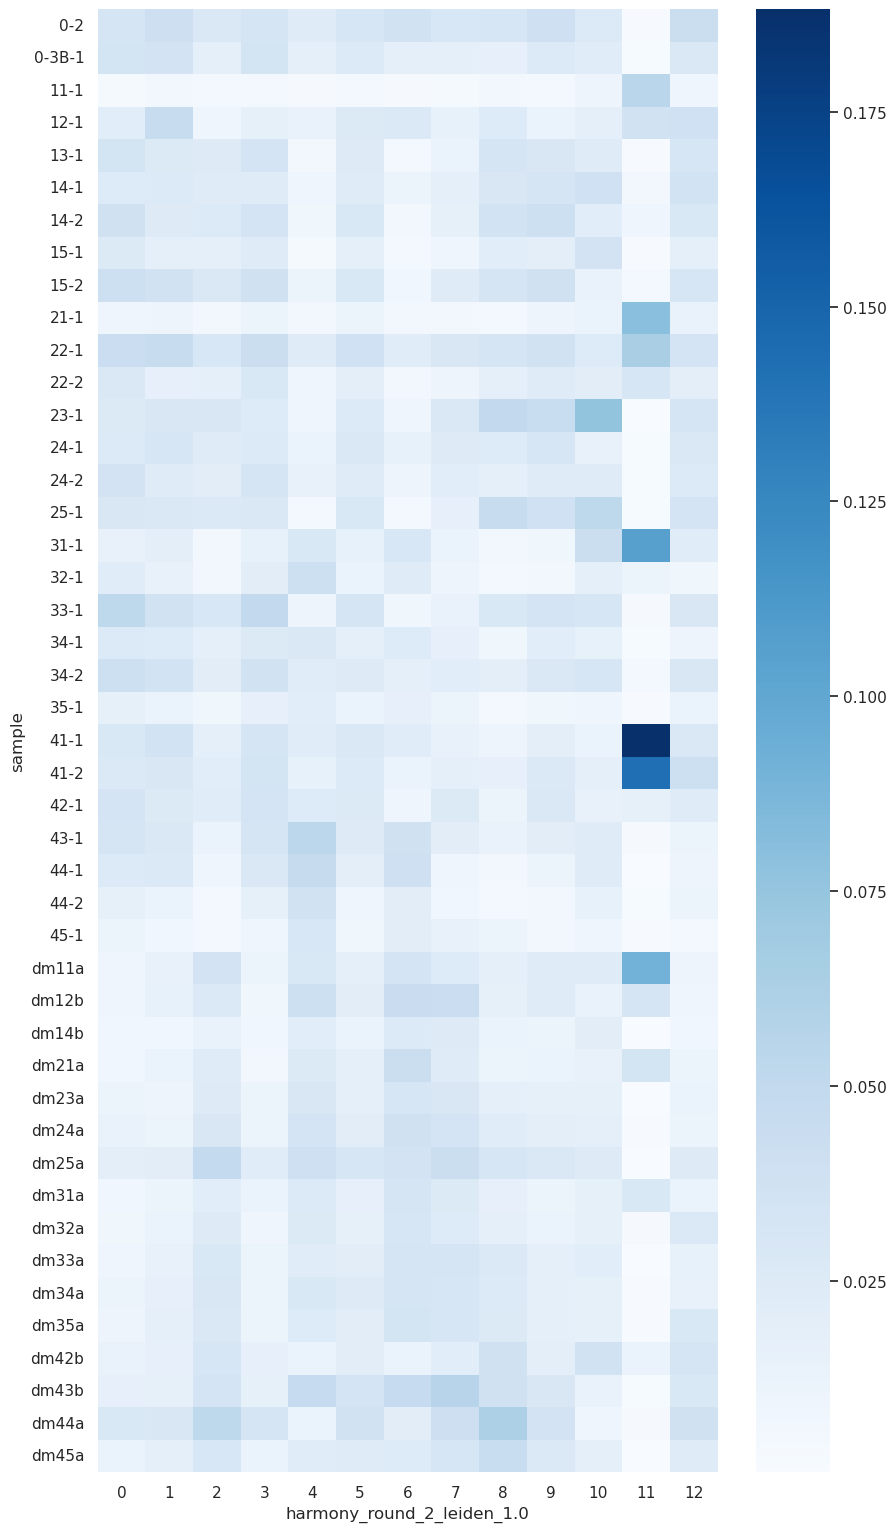

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 19))
sns.heatmap(pd.crosstab(adata_filt.obs["sample"], adata_filt.obs[clustering_key], normalize="columns"), cmap="Blues", ax=ax)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


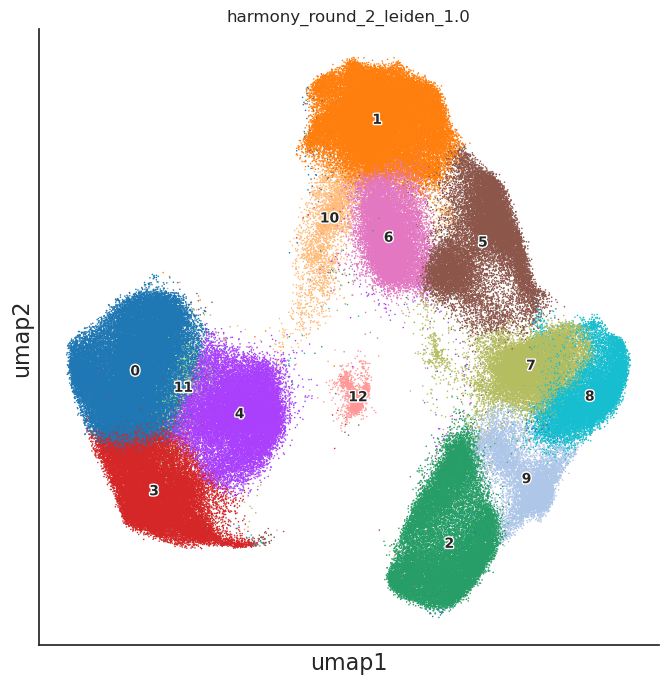

In [39]:
pretty_umap(
    adata_filt,
    color_key=clustering_key,
    s=5,
    figsize=(8, 8),
    legend_fontsize=10,
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


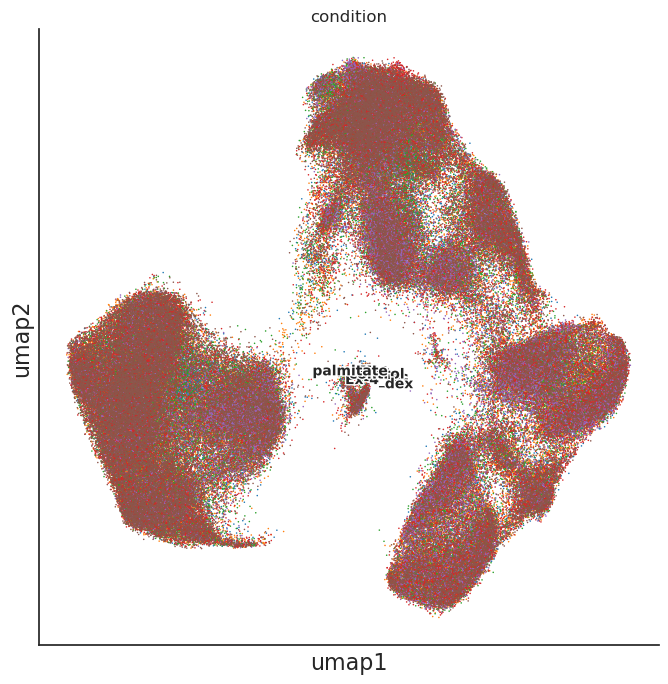

In [40]:
pretty_umap(
    adata_filt,
    color_key="condition",
    s=5,
    figsize=(8, 8),
    legend_fontsize=10,
)

# Filter out clusters

In [41]:
# Clusters to remove
clusters_to_remove = []
reasons = []

In [44]:
# Remove clusters
adata_final = adata_filt[~adata_filt.obs[clustering_key].isin(clusters_to_remove)].copy()
adata_final

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 236613 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

In [42]:
# Save the barcodes and cluster assignments that will be removed
filter_bcs = adata_filt.obs[adata_filt.obs[clustering_key].isin(clusters_to_remove)].index.tolist()
filter_bcs_df = adata_filt.obs.loc[filter_bcs][clustering_key]
filter_bcs_df.index.name = "barcode"
filter_bcs_df.to_csv(os.path.join(path_outdir, f"filtered_bcs.txt"), sep="\t")

In [43]:
# plain text file with clusters removed
with open(os.path.join(path_outdir, f"filtered_clusters.txt"), "w") as f:
    for cluster, reason in zip(clusters_to_remove, reasons):
        f.write(f"{cluster}\t{reason}\n")

In [45]:
del adata_filt

# Clean up and save

## Full anndata

In [46]:
adata_final.obs.to_csv(os.path.join(path_outdir, "cell_metadata.tsv"), sep="\t", index=True)

In [47]:
adata_final.write(os.path.join(path_outdir, "full.h5ad"))

In [5]:
adata_final = sc.read_h5ad("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/4_integration/rna/integrate/round_2_12-1/full.h5ad")
adata_final

AnnData object with n_obs × n_vars = 236613 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

## Slim version (keep raw counts, obs, var and X_umap and X_pca)

In [6]:
adata_slim = adata_final.copy()
adata_slim

AnnData object with n_obs × n_vars = 236613 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

In [7]:
# Counts
adata_slim.layers["counts"] = adata_slim.layers[counts_layer].copy()
adata_slim.X = adata_slim.layers["counts"].copy()
adata_slim

AnnData object with n_obs × n_vars = 236613 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

In [8]:
# Delete unnecessary data
del adata_slim.uns
del adata_slim.obsp

if counts_layer != "counts":
    del adata_slim.layers[counts_layer]

if "log1p_norm" in adata_slim.layers.keys():
    del adata_slim.layers["log1p_norm"]

if "sctransform_scale_data" in adata_slim.obsm.keys():
    del adata_slim.obsm["sctransform_scale_data"]

if umap_key != "X_umap":
    del adata_slim.obsm[umap_key]

if pca_key != "X_pca":
    del adata_slim.obsm[pca_key]

adata_slim

AnnData object with n_obs × n_vars = 236613 × 36601
    obs: 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'atac_TSS_fr

In [9]:
adata_slim.write(os.path.join(path_outdir, "slim.h5ad"))

# DONE!

---

# To add

In [35]:
# Get cell cycle genes
cell_cycle_genes = [x.strip() for x in open('/cellar/users/aklie/projects/igvf/single_cell_utilities/resources/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_filt.var_names]

In [36]:
# Save raw in adata_filt
adata_filt.raw = adata_filt

In [38]:
# scale, note that .X contains scaled data now
sc.pp.scale(adata_filt)

In [43]:
# Score genes
sc.tl.score_genes_cell_cycle(adata_filt, s_genes=s_genes, g2m_genes=g2m_genes)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


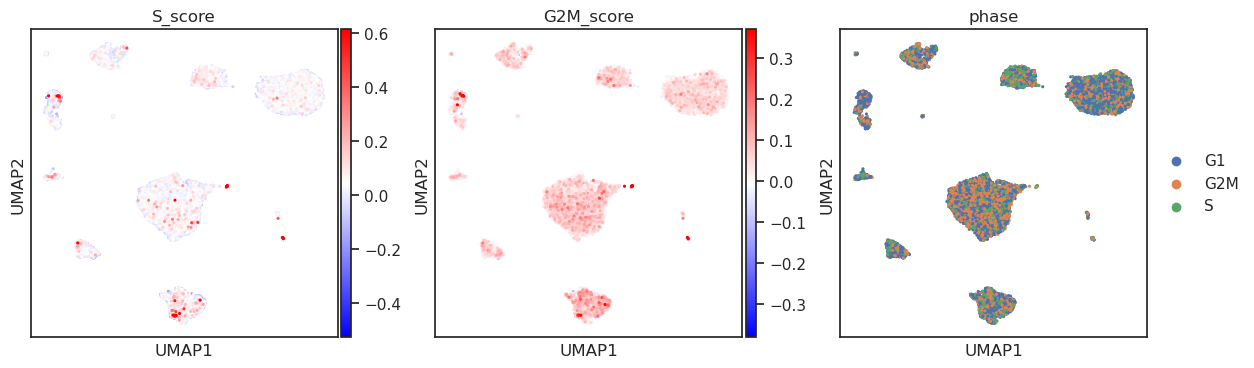

In [44]:
# Plot cell cycle scores as UMAP
with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata_filt, color=["S_score", "G2M_score", "phase"], cmap="bwr", vmin="p0", vmax="p99.9", ncols=3, s=20, wspace=0.2, show=False)
    #plt.savefig(os.path.join(path_outdir, "cell_cycle_scoring", "cell_cycle_umap.png"), bbox_inches="tight")
    #plt.close()

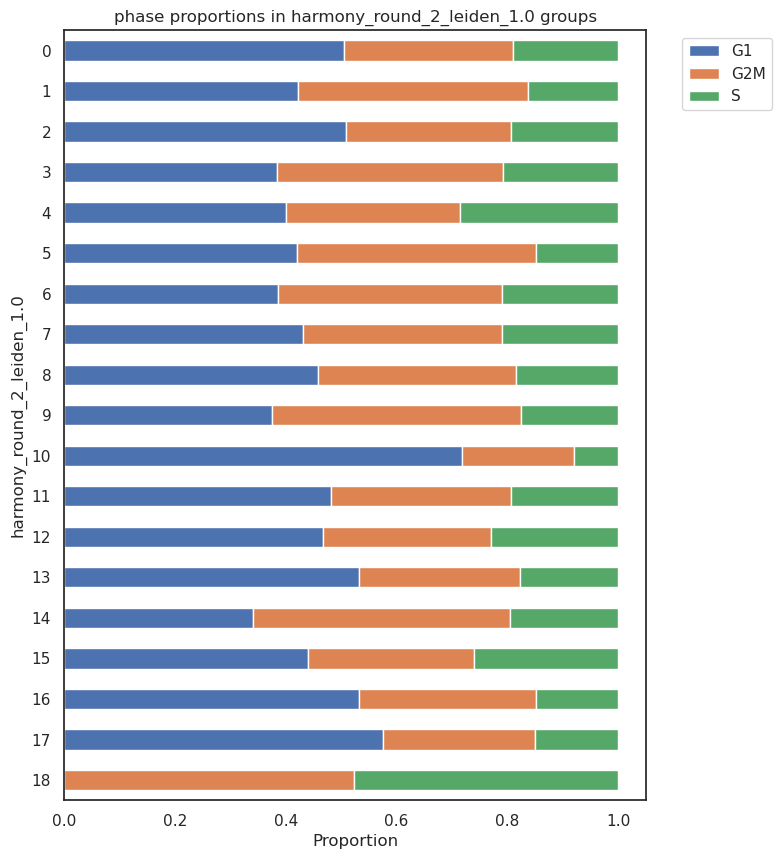

In [45]:
# Plot cluster proportions by phase
grouped_proportion_barplot(
    adata_filt,
    groupby_key=clustering_key,
    proportion_key="phase",
    groupby_order=cluster_order,
    #save=os.path.join(path_outdir, "clusters", "phase_proportions_by_cluster.png")
)